15mins

In [1]:
import json
import random
import numpy as np
from tqdm import tqdm

from rasengan.problems.facility_location_problem import generate_flp
from rasengan.problems.set_cover_problem import generate_scp
from rasengan.problems.k_partition_problem import generate_kpp
from rasengan.problems.graph_coloring_problem import generate_gcp
from rasengan.solvers.optimizers import CobylaOptimizer
from rasengan.solvers.qiskit import DdsimProvider
from rasengan.solvers.qiskit.explorer import QtoExplorer

np.random.seed(0x7f)
random.seed(0x7f)

num_cases = 1

flp_problems_pkg, flp_configs_pkg = generate_flp(num_cases, [(1, 2), (2, 3), (3, 3), (3, 4)], 10, 30)
kpp_problems_pkg, kpp_configs_pkg = generate_kpp(num_cases, [(4, 2, 3), (5, 3, 4), (6, 3, 5), (7, 3, 6)], 1, 20)
scp_problems_pkg, scp_configs_pkg = generate_scp(num_cases, [(4, 4), (5, 5), (6, 6), (7, 7)])
gcp_problems_pkg, gcp_configs_pkg = generate_gcp(num_cases, [(3, 1), (3, 2), (4, 1), (4, 2)])

problems_pkg = [flp_problems_pkg, kpp_problems_pkg, scp_problems_pkg, gcp_problems_pkg]

space_list = []

for problem in tqdm(problems_pkg, desc="Analysing space"):
    problem_space_list = []
    for benchmark in tqdm(problem, desc="    processing", leave=False):
        opt = CobylaOptimizer(max_iter=200)
        aer = DdsimProvider()
        benchmark[0].set_penalty_lambda(200)
        solver = QtoExplorer(
            prb_model=benchmark[0],
            optimizer=opt,
            provider=aer,
            shots=1000,
        )
        exp_list, _, _ = solver.explore()
        problem_space_list.append(exp_list)
    space_list.append(problem_space_list)

with open("space_explore.json", "w") as f:
    json.dump(space_list, f)

Analysing space: 100%|██████████| 4/4 [04:08<00:00, 62.15s/it]


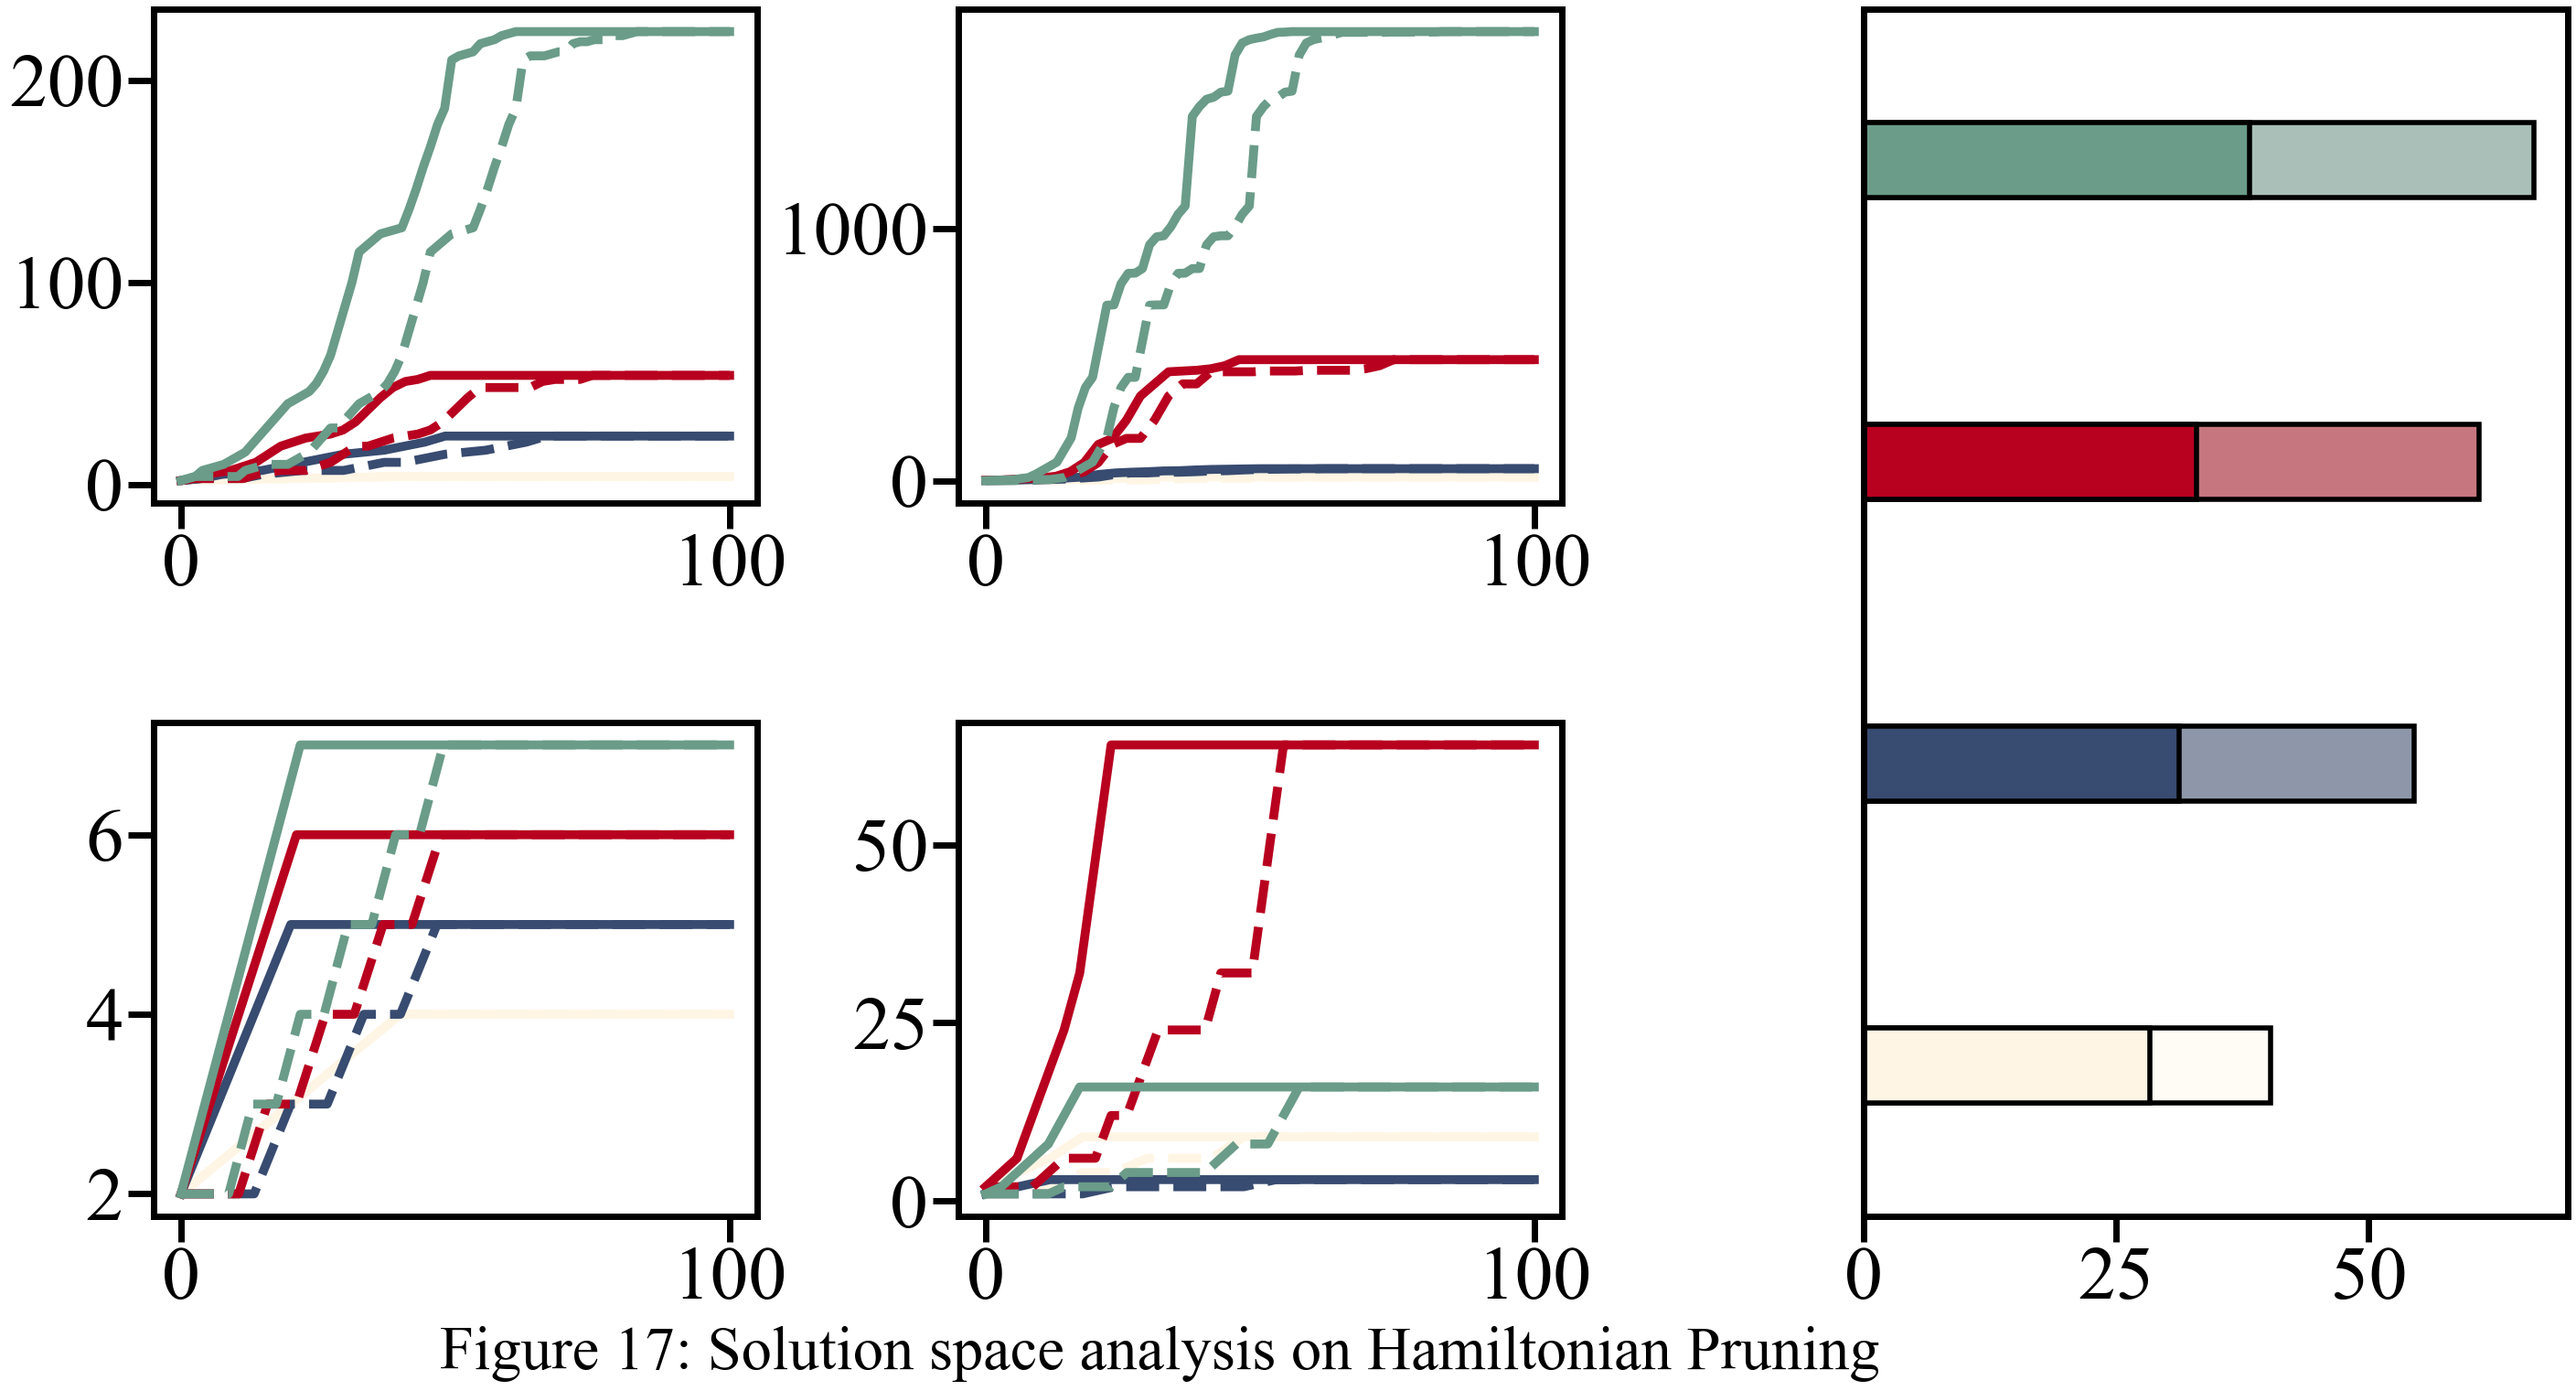

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

with open("space_explore.json", "r") as f:
    space_list = json.load(f)

# 全局绘图参数设置
mpl.rcParams.update({
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'font.family': 'Times New Roman',
    'font.size': 60,
    'axes.unicode_minus': False,
    'mathtext.fontset': 'custom',
    'mathtext.rm': 'Times New Roman',
    'mathtext.it': 'Times New Roman:italic',
    'mathtext.bf': 'Times New Roman:bold',
    'axes.linewidth': 5,
    'xtick.major.size': 20,
    'xtick.major.width': 5,
    'xtick.minor.size': 10,
    'xtick.minor.width': 3,
    'ytick.major.size': 20,
    'ytick.major.width': 5,
    'ytick.minor.size': 10,
    'ytick.minor.width': 3,
    "lines.markersize": 35,
    "lines.markeredgewidth": 4,
    "markers.fillstyle": 'full',
    'lines.markerfacecolor': '#f8d941',
    'lines.markeredgecolor': 'black',
})

# 图形参数与初始化
plt_x, plt_y = 0.3, 0.45
box_x, box_y = 0.4, 0.65
fig = plt.figure(figsize=(22, 12))
axes = [
    plt.axes((0, box_y, plt_x, plt_y)),
    plt.axes((0, 0, plt_x, plt_y)),
    plt.axes((box_x, box_y, plt_x, plt_y)),
    plt.axes((box_x, 0, plt_x, plt_y)),
]
bar_ax = plt.axes((0.85, 0, 0.35, 1.1))

colors = ['#FFF5E4', '#384B70', '#B8001F', '#6A9C89']
colors_2 = ['#fffcf5', '#8d97a9', '#c6767f', '#a9bfb7']
labels = ['HeaSolver', 'PenaltySolver', 'ChocoSolver', 'QtoSimplifyDiscardSegmentedSolver']
cal_list = [0] * 4
cal_list_2 = [0] * 4

# 均匀抽样函数
def get_uniform_points(x, y, max_points=30):
    indices = np.linspace(0, len(x) - 1, num=max_points, dtype=int)
    return [x[i] for i in indices], [y[i] for i in indices]

# 遍历每组图和数据
for ax, data, idx in zip(axes, space_list, range(4)):
    processed_data = []
    for d in data:
        unique = sorted(set(d))
        filled = unique + [unique[-1]] * (len(d) - len(unique))
        processed_data.append(filled)

    # 计算统计
    max_orig = [d.index(max(d)) for d in data]
    max_proc = [d.index(max(d)) for d in processed_data]
    lengths = [len(d) for d in data]

    for i, (a, b, L) in enumerate(zip(max_orig, max_proc, lengths)):
        cal_list[i] += a / L / 4 * 100
        cal_list_2[i] += b / L / 4 * 100

    # 绘图
    for i, (orig, proc) in enumerate(zip(data, processed_data)):
        x_orig = np.linspace(0, 100, len(orig))
        x_proc = np.linspace(0, 100, len(proc))
        ax.plot(x_orig, orig, label=f'{labels[i]} (Original)', color=colors[i], linestyle='--', linewidth=7)
        ax.plot(x_proc, proc, label=f'{labels[i]} (Processed)', color=colors[i], linestyle='-', linewidth=7)

# 绘制条形图
for i in range(4):
    bar_ax.barh(i, cal_list[i], height=0.25, color=colors_2[i], edgecolor="black", linewidth=4)
    bar_ax.barh(i, cal_list_2[i], height=0.25, color=colors[i], edgecolor="black", linewidth=4, alpha=1)

bar_ax.set_ylim(-0.5, 3.5)
bar_ax.set_yticks([])

title = "Figure 17: Solution space analysis on Hamiltonian Pruning"
plt.suptitle(title, y=-0.1, fontsize=48)
plt.savefig(f'{title}.svg', bbox_inches='tight')
plt.show()